Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
df=pd.read_csv('/kaggle/input/shampoo-saled-dataset/shampoo_sales.csv')

In [ ]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


Changing datetime to appropriate format

In [ ]:
def parse_date(x):
    return datetime.strptime('200'+x, '%Y-%m')

df = pd.read_csv("/kaggle/input/shampoo-saled-dataset/shampoo_sales.csv",index_col=[0], parse_dates=[0], date_parser=parse_date)
df.head()

/tmp/ipykernel_33/1582483131.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("/kaggle/input/shampoo-saled-dataset/shampoo_sales.csv",index_col=[0], parse_dates=[0], date_parser=parse_date)


,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


In [ ]:
df.head()

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


Plotting Data

<Axes: xlabel='Month'>

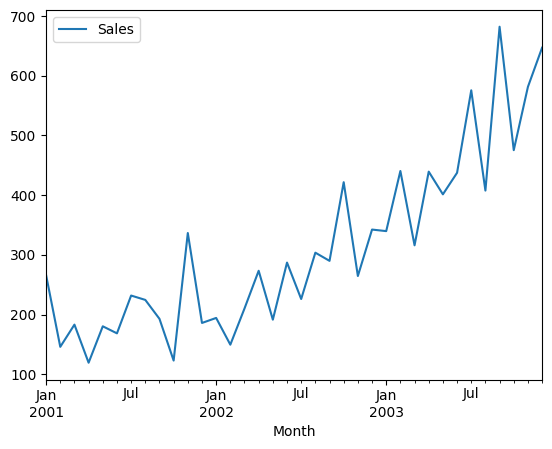

In [ ]:
df.plot()

In [ ]:
df

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,192.8


Getting Additional Insights using statsmodels library

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decom = seasonal_decompose(df, model='additive')
actual = decom.observed
trend = decom.trend
seasonal = decom.seasonal
residual = decom.resid

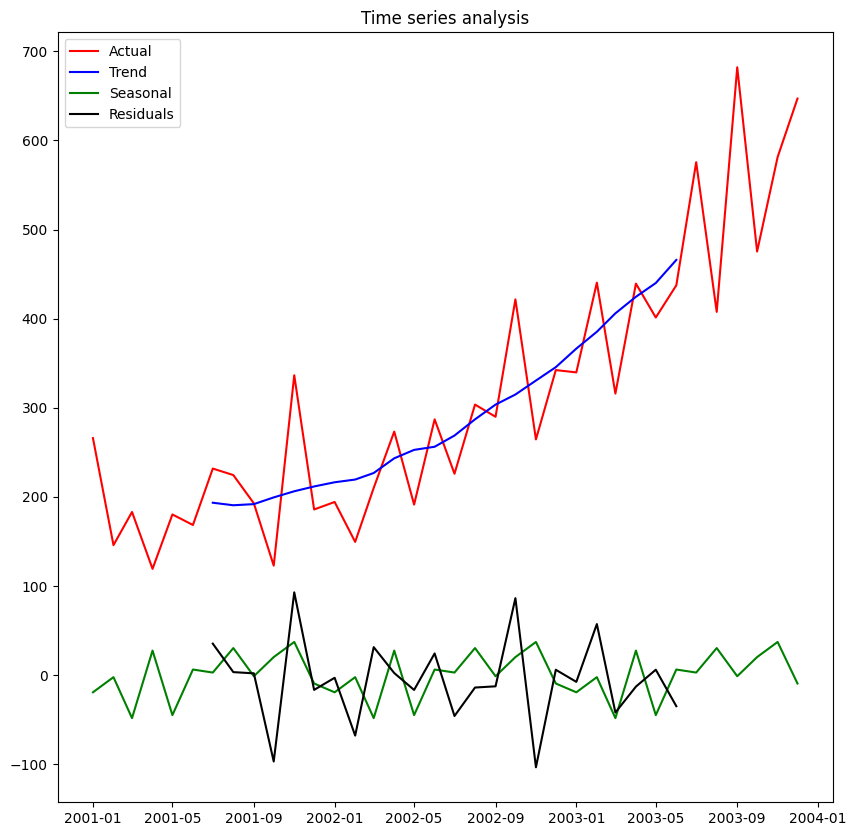

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual,color='red',label='Actual')
plt.plot(trend,color='blue', label='Trend')
plt.plot(seasonal,color='green', label='Seasonal')
plt.plot(residual, color='black', label='Residuals')
plt.legend()
plt.title("Time series analysis")
plt.show()

Plotting Autocorrelation in the data

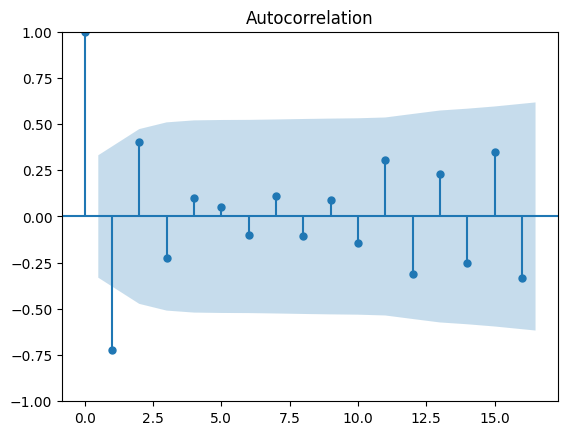

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Sales'].diff(1).dropna())
plt.show()

In [ ]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler.fit_transform(df)

Creating Custom Dataset

In [ ]:
# Create a custom dataset class
class ShampooSalesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

        # Normalize data
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.data['Sales'] = self.scaler.fit_transform(self.data['Sales'].values.reshape(-1, 1))

        # Create sequences
        self.sequences = self.create_sequences()

    def create_sequences(self):
        sequences = []
        for i in range(len(self.data) - self.sequence_length):
            seq = self.data['Sales'].values[i:i+self.sequence_length]
            label = self.data['Sales'].values[i+self.sequence_length:i+self.sequence_length+1]
            sequences.append((seq, label))
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, label = self.sequences[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Creating Train, test and Validation Dataloaders

In [ ]:
from torch.utils.data import DataLoader, random_split

def create_dataloaders(dataset, batch_size=64, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True):
    # Split the dataset into train, validation, and test sets
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create DataLoader instances for train, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader, test_loader


sequence_length=2
shampoo_dataset = ShampooSalesDataset(df, sequence_length)
train_loader, val_loader, test_loader = create_dataloaders(shampoo_dataset, batch_size=64, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True)


Initial Model for LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


Parameters

In [ ]:
# Initialize the model
input_size = 1
hidden_size =50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Training and Plotting losses

Epoch [1/100], Train Loss: 0.2839, Val Loss: 0.3460
Epoch [2/100], Train Loss: 0.2737, Val Loss: 0.3293
Epoch [3/100], Train Loss: 0.2621, Val Loss: 0.3156
Epoch [4/100], Train Loss: 0.2435, Val Loss: 0.2971
Epoch [5/100], Train Loss: 0.2199, Val Loss: 0.2563
Epoch [6/100], Train Loss: 0.1856, Val Loss: 0.1917
Epoch [7/100], Train Loss: 0.1411, Val Loss: 0.1290
Epoch [8/100], Train Loss: 0.0962, Val Loss: 0.0902
Epoch [9/100], Train Loss: 0.0590, Val Loss: 0.1111
Epoch [10/100], Train Loss: 0.0694, Val Loss: 0.1283
Epoch [11/100], Train Loss: 0.1095, Val Loss: 0.1372
Epoch [12/100], Train Loss: 0.1015, Val Loss: 0.1248
Epoch [13/100], Train Loss: 0.0825, Val Loss: 0.0967
Epoch [14/100], Train Loss: 0.0613, Val Loss: 0.0834
Epoch [15/100], Train Loss: 0.0558, Val Loss: 0.0863
Epoch [16/100], Train Loss: 0.0585, Val Loss: 0.0975
Epoch [17/100], Train Loss: 0.0636, Val Loss: 0.1098
Epoch [18/100], Train Loss: 0.0696, Val Loss: 0.1162
Epoch [19/100], Train Loss: 0.0733, Val Loss: 0.1149
Ep

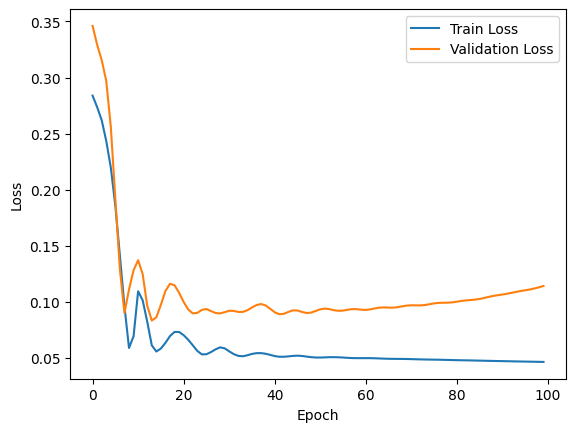

In [ ]:
def train_and_plot_losses(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(-1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        # Validation loss
        model.eval()
        epoch_val_losses = []

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch.unsqueeze(-1))
                val_loss = criterion(val_outputs, y_val_batch)
                epoch_val_losses.append(val_loss.item())

        avg_train_loss = np.mean(epoch_train_losses)
        avg_val_loss = np.mean(epoch_val_losses)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Plot training and validation losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


train_and_plot_losses(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Testing the data (MSE)

Test Loss: 0.1240
Mean Squared Error (MSE): 9816.7197


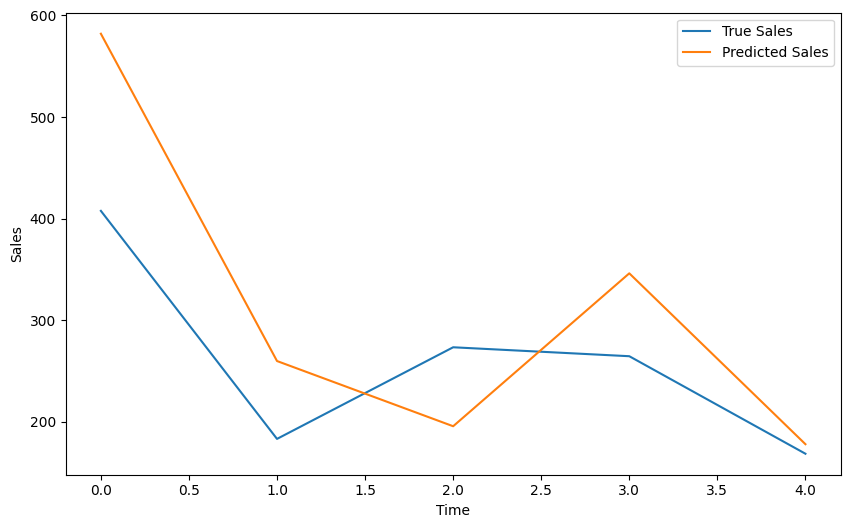

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_and_plot(model, test_loader, criterion, scaler):
    model.eval()
    test_losses = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            test_outputs = model(X_test_batch.unsqueeze(-1))
            test_loss = criterion(test_outputs, y_test_batch)
            test_losses.append(test_loss.item())

    # Calculate average test loss
    avg_test_loss = np.mean(test_losses)
    print(f'Test Loss: {avg_test_loss:.4f}')

    # Inverse transform the predictions to the original scale
    test_outputs = scaler.inverse_transform(test_outputs.cpu().numpy())
    y_test = scaler.inverse_transform(y_test_batch.cpu().numpy())

    # Calculate Mean Squared Error (MSE)
    mse_loss = mean_squared_error(y_test, test_outputs)
    print(f'Mean Squared Error (MSE): {mse_loss:.4f}')

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='True Sales')
    plt.plot(test_outputs, label='Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Call the function
evaluate_and_plot(model, test_loader, criterion, scaler)


Predicting Future data

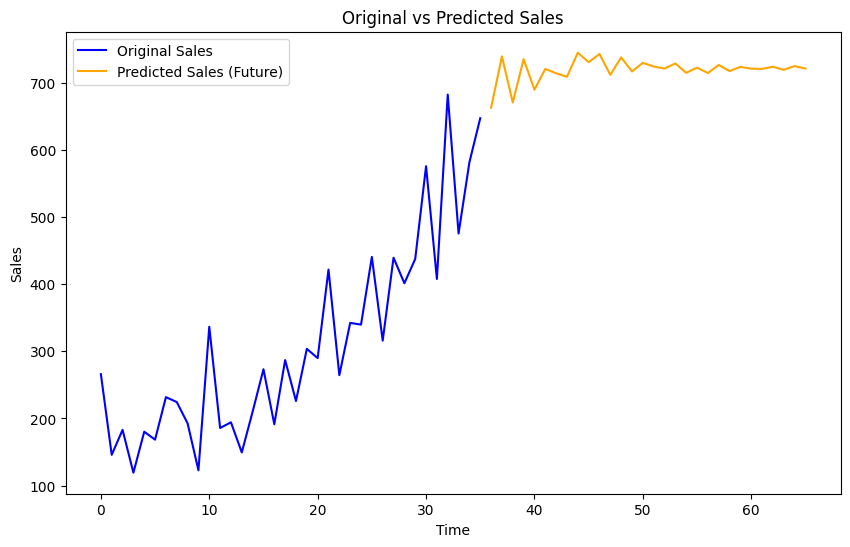

In [ ]:
def predict_and_plot_future(model, df, scaler, sequence_length=10, future_frames=30):
    # Set the model to evaluation mode
    model.eval()
#     print(df['Sales'])

    # Prepare the last sequence from the initial dataset for prediction
    last_sequence = torch.tensor(df['Sales'].values[-sequence_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    # Make predictions for the next frames
    future_predictions = []

    for _ in range(future_frames):
        with torch.no_grad():
            # Predict the next frame
            prediction = model(last_sequence)
            future_predictions.append(prediction.item())

            # Update the last sequence for the next prediction
            last_sequence = torch.cat((last_sequence[:, 1:], prediction.unsqueeze(-1)), dim=1)

    # Inverse transform the predicted values to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    original=scaler.inverse_transform(np.array(df['Sales']).reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(df)), original, label='Original Sales', color='blue')
    plt.plot(np.arange(len(df), len(df) + future_frames), future_predictions, label='Predicted Sales (Future)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('Original vs Predicted Sales')
    plt.legend()
#     plt.grid(True)
    plt.show()


predict_and_plot_future(model, df, scaler, sequence_length=10, future_frames=30)


**Hyperparameter Tuning**

Improving the model

In [ ]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Initialize the model
input_size = 1
hidden_size = 40
num_layers = 2
output_size = 1
dr=0.3

model_improved = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size,dr)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.01)


Epoch [1/100], Train Loss: 0.3056, Val Loss: 0.3732
Epoch [2/100], Train Loss: 0.2653, Val Loss: 0.3476
Epoch [3/100], Train Loss: 0.2607, Val Loss: 0.3367
Epoch [4/100], Train Loss: 0.2608, Val Loss: 0.3232
Epoch [5/100], Train Loss: 0.2362, Val Loss: 0.3025
Epoch [6/100], Train Loss: 0.2213, Val Loss: 0.2771
Epoch [7/100], Train Loss: 0.2087, Val Loss: 0.2451
Epoch [8/100], Train Loss: 0.1785, Val Loss: 0.2042
Epoch [9/100], Train Loss: 0.1533, Val Loss: 0.1659
Epoch [10/100], Train Loss: 0.1148, Val Loss: 0.1959
Epoch [11/100], Train Loss: 0.0984, Val Loss: 0.2526
Epoch [12/100], Train Loss: 0.1172, Val Loss: 0.1710
Epoch [13/100], Train Loss: 0.0863, Val Loss: 0.1053
Epoch [14/100], Train Loss: 0.1215, Val Loss: 0.1105
Epoch [15/100], Train Loss: 0.1196, Val Loss: 0.1573
Epoch [16/100], Train Loss: 0.1128, Val Loss: 0.1801
Epoch [17/100], Train Loss: 0.0830, Val Loss: 0.1731
Epoch [18/100], Train Loss: 0.0870, Val Loss: 0.1458
Epoch [19/100], Train Loss: 0.0789, Val Loss: 0.1298
Ep

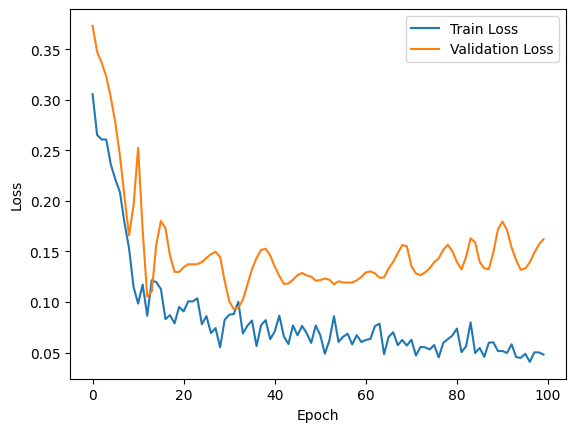

Test Loss: 0.0202
Mean Squared Error (MSE): 1602.5995


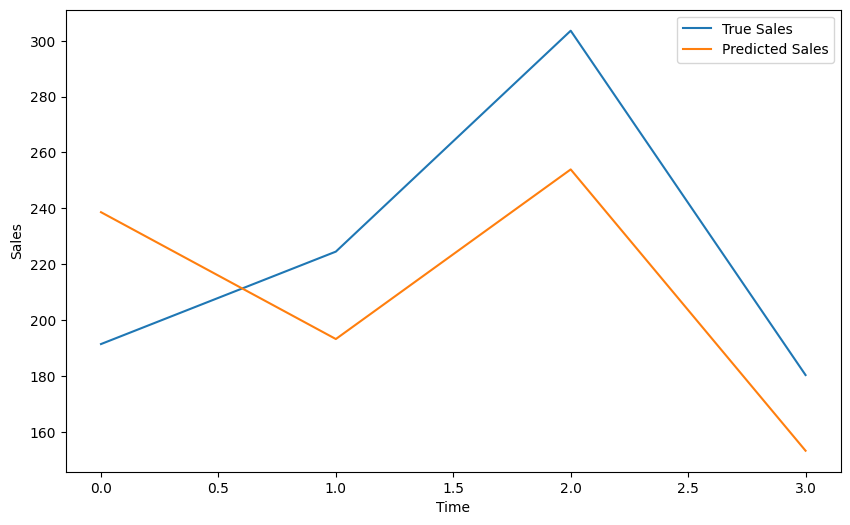

In [ ]:
# Create an instance of the custom dataset
sequence_length = 3
shampoo_dataset = ShampooSalesDataset(df, sequence_length)

# Create DataLoader instances for train, validation, and test sets
train_loader, val_loader, test_loader = create_dataloaders(shampoo_dataset, batch_size=64, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True)

# Train the model
train_and_plot_losses(model_improved, train_loader, val_loader, criterion, optimizer, num_epochs=100)

# Evaluate and plot on the test set
evaluate_and_plot(model_improved, test_loader, criterion, scaler)


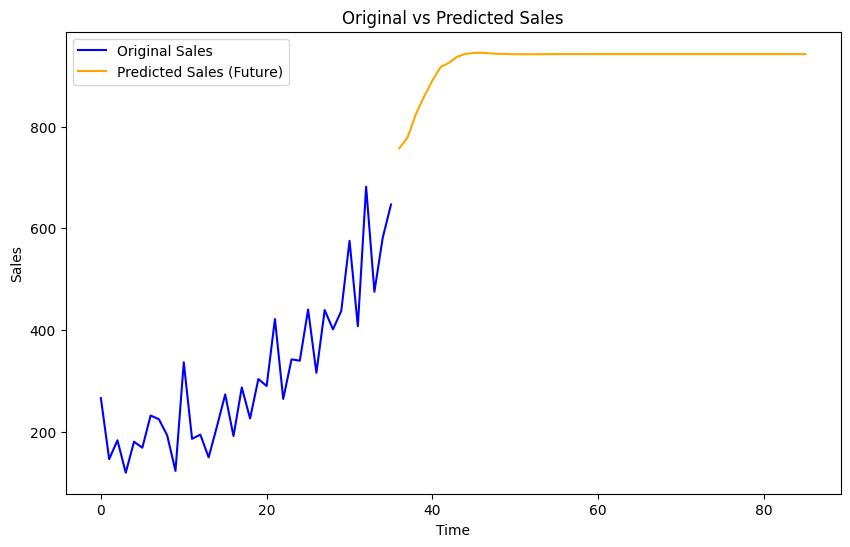

In [ ]:
predict_and_plot_future(model_improved, df, scaler, sequence_length=10, future_frames=50)

Second Improved Model (Trying)

In [ ]:
# Initialize the model
input_size = 1
hidden_size = 80
num_layers = 2
output_size = 1
dr=0.8

model_improved_2 = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size,dr)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_improved_2.parameters(), lr=0.01)


Epoch [1/100], Train Loss: 0.0787, Val Loss: 0.0852
Epoch [2/100], Train Loss: 0.1420, Val Loss: 0.0877
Epoch [3/100], Train Loss: 0.1020, Val Loss: 0.0938
Epoch [4/100], Train Loss: 0.0863, Val Loss: 0.1020
Epoch [5/100], Train Loss: 0.0952, Val Loss: 0.1156
Epoch [6/100], Train Loss: 0.1182, Val Loss: 0.1072
Epoch [7/100], Train Loss: 0.1003, Val Loss: 0.1021
Epoch [8/100], Train Loss: 0.1137, Val Loss: 0.0998
Epoch [9/100], Train Loss: 0.1174, Val Loss: 0.0964
Epoch [10/100], Train Loss: 0.1098, Val Loss: 0.0912
Epoch [11/100], Train Loss: 0.0975, Val Loss: 0.0921
Epoch [12/100], Train Loss: 0.1099, Val Loss: 0.0939
Epoch [13/100], Train Loss: 0.0872, Val Loss: 0.0985
Epoch [14/100], Train Loss: 0.0888, Val Loss: 0.0990
Epoch [15/100], Train Loss: 0.1543, Val Loss: 0.1082
Epoch [16/100], Train Loss: 0.1297, Val Loss: 0.1057
Epoch [17/100], Train Loss: 0.0786, Val Loss: 0.1007
Epoch [18/100], Train Loss: 0.0869, Val Loss: 0.0977
Epoch [19/100], Train Loss: 0.0991, Val Loss: 0.0954
Ep

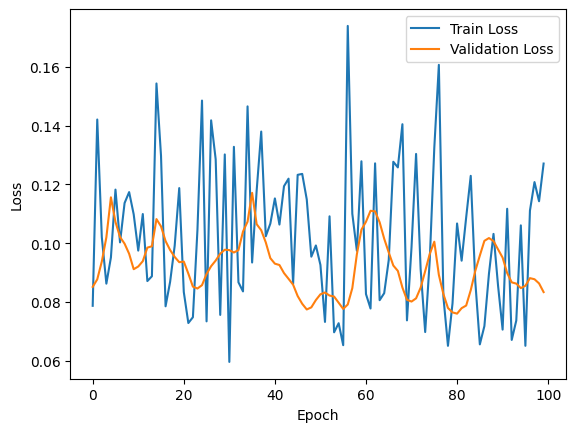

Test Loss: 0.0125
Mean Squared Error (MSE): 989.4921


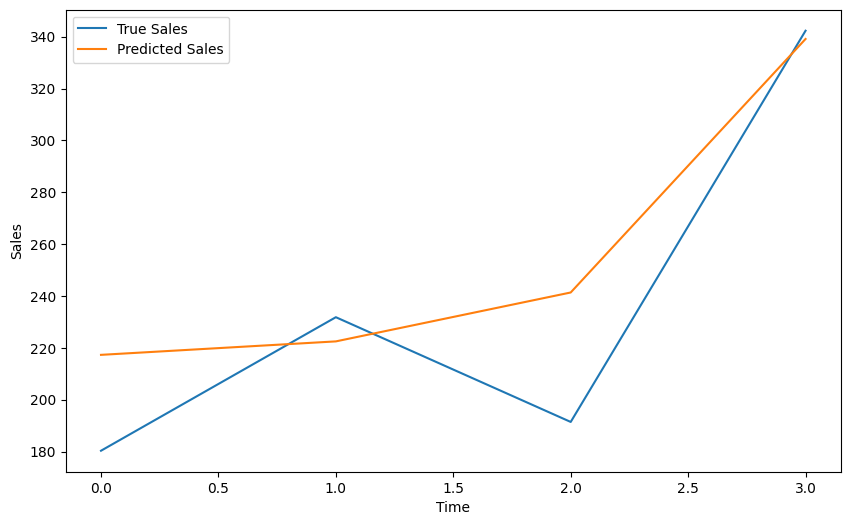

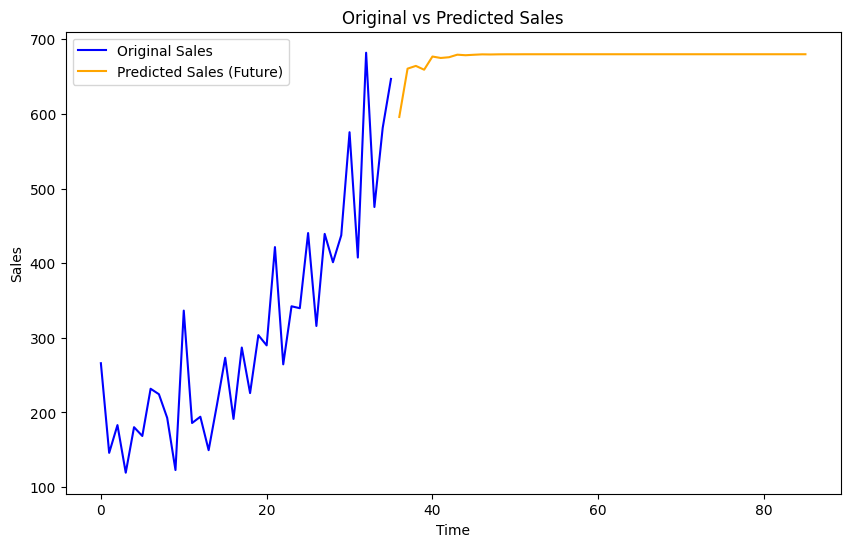

In [ ]:
# Create an instance of the custom dataset
sequence_length = 3
shampoo_dataset = ShampooSalesDataset(df, sequence_length)

# Create DataLoader instances for train, validation, and test sets
train_loader, val_loader, test_loader = create_dataloaders(shampoo_dataset, batch_size=64, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True)

# Train the model
train_and_plot_losses(model_improved_2, train_loader, val_loader, criterion, optimizer, num_epochs=100)

# Evaluate and plot on the test set
evaluate_and_plot(model_improved_2, test_loader, criterion, scaler)

predict_and_plot_future(model_improved_2, df, scaler, sequence_length, future_frames=50)


The above model performs the best since it has the least MSE error

Third Model

Epoch [1/100], Train Loss: 0.3183, Val Loss: 0.2617
Epoch [2/100], Train Loss: 0.2757, Val Loss: 0.1435
Epoch [3/100], Train Loss: 0.2543, Val Loss: 0.1395
Epoch [4/100], Train Loss: 0.2183, Val Loss: 0.1527
Epoch [5/100], Train Loss: 0.1788, Val Loss: 0.1015
Epoch [6/100], Train Loss: 0.1135, Val Loss: 0.0684
Epoch [7/100], Train Loss: 0.1263, Val Loss: 0.1573
Epoch [8/100], Train Loss: 0.1168, Val Loss: 0.1728
Epoch [9/100], Train Loss: 0.1131, Val Loss: 0.0894
Epoch [10/100], Train Loss: 0.0859, Val Loss: 0.0527
Epoch [11/100], Train Loss: 0.1102, Val Loss: 0.0511
Epoch [12/100], Train Loss: 0.0889, Val Loss: 0.0708
Epoch [13/100], Train Loss: 0.0904, Val Loss: 0.0902
Epoch [14/100], Train Loss: 0.0813, Val Loss: 0.0927
Epoch [15/100], Train Loss: 0.0905, Val Loss: 0.0869
Epoch [16/100], Train Loss: 0.0815, Val Loss: 0.0841
Epoch [17/100], Train Loss: 0.0691, Val Loss: 0.0856
Epoch [18/100], Train Loss: 0.0827, Val Loss: 0.1044
Epoch [19/100], Train Loss: 0.0733, Val Loss: 0.1156
Ep

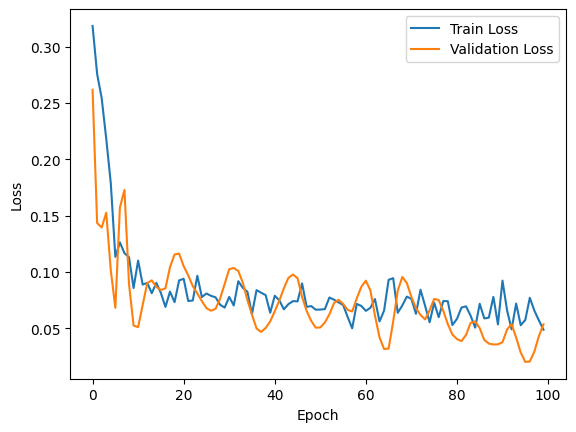

Test Loss: 0.0384
Mean Squared Error (MSE): 3042.3398


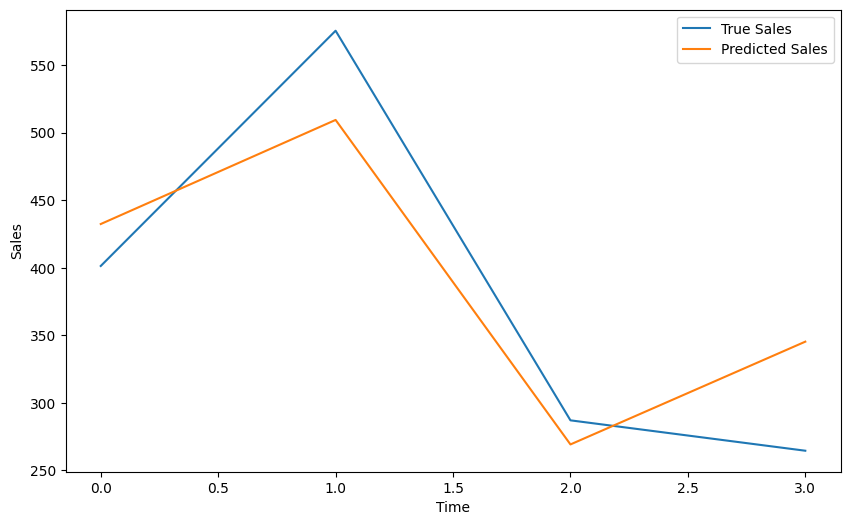

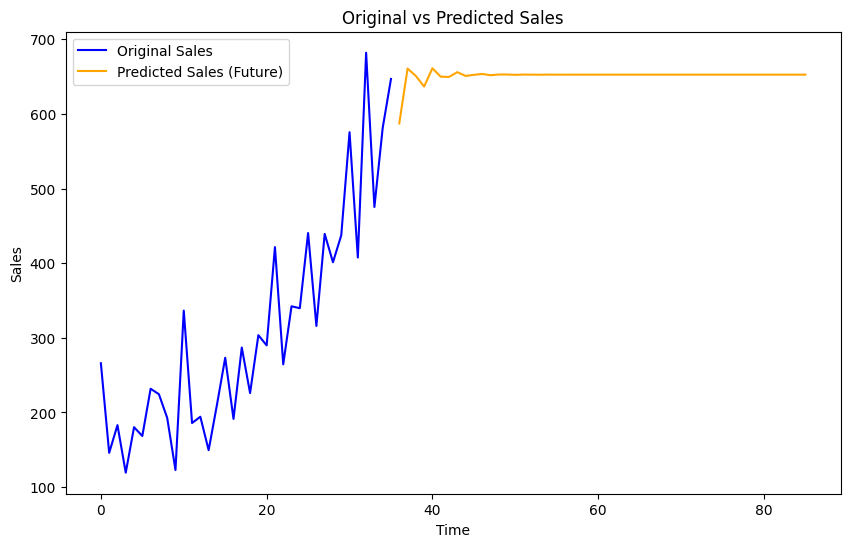

In [ ]:
# Initialize the model
input_size = 1
hidden_size = 100
num_layers = 2
output_size = 1
dr=0.4

model_improved_3 = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size,dr)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_improved_3.parameters(), lr=0.01)


# Create an instance of the custom dataset
sequence_length = 3
shampoo_dataset = ShampooSalesDataset(df, sequence_length)

# Create DataLoader instances for train, validation, and test sets
train_loader, val_loader, test_loader = create_dataloaders(shampoo_dataset, batch_size=64, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, shuffle=True)

# Train the model
train_and_plot_losses(model_improved_3, train_loader, val_loader, criterion, optimizer, num_epochs=100)

# Evaluate and plot on the test set
evaluate_and_plot(model_improved_3, test_loader, criterion, scaler)

predict_and_plot_future(model_improved_3, df, scaler, sequence_length, future_frames=50)

